In [27]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten, MultiHeadAttention, LayerNormalization
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.layers import Input, Bidirectional, Attention

In [28]:
# Transformer Encoder Layer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Multi-head attention
    attention_output = MultiHeadAttention(key_dim=head_size, num_heads=num_heads)(inputs, inputs)
    attention_output = Dropout(dropout)(attention_output)

    # Match the dimensions of the attention output
    attention_output_dim = attention_output.shape[-1]
    attention_output = Dense(attention_output_dim)(attention_output)

    attention_output = LayerNormalization(epsilon=1e-6)(inputs + attention_output)

    # Feed-forward part
    ffn_output = Dense(ff_dim, activation="relu")(attention_output)
    ffn_output = Dense(attention_output_dim)(ffn_output) # Match the dimensions of the attention output
    ffn_output = Dropout(dropout)(ffn_output)
    sequence_output = LayerNormalization(epsilon=1e-6)(attention_output + ffn_output)

    return sequence_output

In [29]:
# Read and preprocess data
data = pd.read_csv('E:/BTC-USD.csv')
X = []
Y = []
window_size = 100
for i in range(1, len(data) - window_size - 1, 1):
    first = data.iloc[i, 4]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((data.iloc[i + j, 4] - first) / first)
    temp2.append((data.iloc[i + window_size, 4] - first) / first)
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2).reshape(1, 1))

In [30]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42,shuffle=True)

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0], 1, 100, 1)
test_X = test_X.reshape(test_X.shape[0], 1, 100, 1)

In [31]:
# Input layer
inputs = Input(shape=(1, 100, 1))

# Model definition
model = tf.keras.Sequential()

# CNN layers
x = TimeDistributed(Conv1D(64, kernel_size=5, activation='relu'))(inputs)
x = TimeDistributed(MaxPooling1D(2))(x)
x = TimeDistributed(Conv1D(128, kernel_size=5, activation='relu'))(x)
x = TimeDistributed(MaxPooling1D(2))(x)
x = TimeDistributed(Conv1D(64, kernel_size=5, activation='relu'))(x)
x = TimeDistributed(MaxPooling1D(2))(x)
x = TimeDistributed(Flatten())(x)

# Transformer encoder layer
x = transformer_encoder(x, head_size=256, num_heads=4, ff_dim=256, dropout=0.1)

# LSTM layers with Attention
x = Bidirectional(LSTM(100, return_sequences=True))(x)
x = Attention()([x, x])
x = Dropout(0.3)(x)
x = Bidirectional(LSTM(100, return_sequences=False))(x)
x = Dropout(0.3)(x)

# Output layer
outputs = Dense(1, activation='linear')(x)

# Compile the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

In [32]:
history = model.fit(train_X, train_Y, validation_data=(test_X, test_Y), epochs=100, batch_size=32, verbose=1, shuffle=True)
model.evaluate(test_X, test_Y)

Epoch 1/100
25/25 [==============================] - 19s 166ms/step - loss: 0.1738 - mse: 0.1738 - mae: 0.2712 - val_loss: 0.0578 - val_mse: 0.0578 - val_mae: 0.1723
Epoch 2/100
25/25 [==============================] - 2s 73ms/step - loss: 0.0449 - mse: 0.0449 - mae: 0.1539 - val_loss: 0.0345 - val_mse: 0.0345 - val_mae: 0.1462
Epoch 3/100
25/25 [==============================] - 2s 71ms/step - loss: 0.0438 - mse: 0.0438 - mae: 0.1481 - val_loss: 0.0271 - val_mse: 0.0271 - val_mae: 0.1193
Epoch 4/100
25/25 [==============================] - 2s 74ms/step - loss: 0.0359 - mse: 0.0359 - mae: 0.1319 - val_loss: 0.0322 - val_mse: 0.0322 - val_mae: 0.1145
Epoch 5/100
25/25 [==============================] - 2s 78ms/step - loss: 0.0320 - mse: 0.0320 - mae: 0.1156 - val_loss: 0.0668 - val_mse: 0.0668 - val_mae: 0.1577
Epoch 6/100
25/25 [==============================] - 2s 85ms/step - loss: 0.0274 - mse: 0.0274 - mae: 0.1121 - val_loss: 0.0202 - val_mse: 0.0202 - val_mae: 0.1093
Epoch 7/100
25

25/25 [==============================] - 3s 102ms/step - loss: 0.0050 - mse: 0.0050 - mae: 0.0473 - val_loss: 0.0057 - val_mse: 0.0057 - val_mae: 0.0516
Epoch 100/100
7/7 [==============================] - 0s 25ms/step - loss: 0.0049 - mse: 0.0049 - mae: 0.0480


[0.004896082915365696, 0.004896082915365696, 0.048041362315416336]

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# predict probabilities for test set
yhat_probs = model.predict(test_X, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]

# Calculate MAE, RMSE, and R^2
mae = mean_absolute_error(test_Y.reshape(-1, 1), yhat_probs)
print('Mean Absolute Error (MAE): %f' % mae)

rmse = np.sqrt(mean_squared_error(test_Y.reshape(-1, 1), yhat_probs))
print('Root Mean Squared Error (RMSE): %f' % rmse)

r2 = r2_score(test_Y.reshape(-1, 1), yhat_probs)
print('R2 Score: %f' % r2)

Mean Absolute Error (MAE): 0.048041
Root Mean Squared Error (RMSE): 0.069972
R2 Score: 0.991045


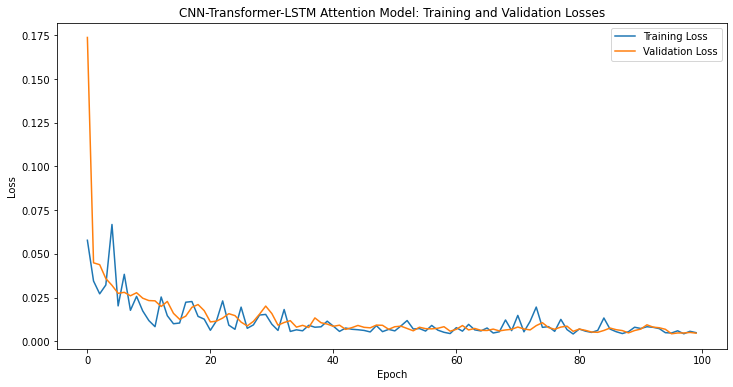

In [34]:
# Plotting the training and validation loss
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(history.history['val_loss'], label='Training Loss')
plt.plot(history.history['loss'], label='Validation Loss')
plt.title('CNN-Transformer-LSTM Attention Model: Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
df = data
# Predict the values using the trained model
predictions = model.predict(test_X)

# Reverse the normalization process
def denormalize(value, first_value):
    return value * first_value + first_value

denormalized_predictions = np.empty_like(predictions)
denormalized_test_Y = np.empty_like(test_Y)

# Apply denormalization
for i in range(len(predictions)):
    first_value = df.iloc[i + window_size, 5]
    denormalized_predictions[i] = denormalize(predictions[i], first_value)
    denormalized_test_Y[i] = denormalize(test_Y[i], first_value)
    
# Compare denormalized predictions with actual values
for i in range(len(denormalized_predictions)):
    print(f"Prediction: {denormalized_predictions[i][0].item():.2f} | Actual: {denormalized_test_Y[i][0].item():.2f}")

7/7 [==============================] - 0s 16ms/step
Prediction: 5765.48 | Actual: 6216.39
Prediction: 8621.07 | Actual: 9022.39
Prediction: 12735.46 | Actual: 13351.63
Prediction: 3890.38 | Actual: 3955.88
Prediction: 6143.10 | Actual: 6246.75
Prediction: 4742.54 | Actual: 5461.51
Prediction: 4986.30 | Actual: 4781.01
Prediction: 6342.83 | Actual: 6512.47
Prediction: 8496.38 | Actual: 8241.37
Prediction: 7751.01 | Actual: 7436.44
Prediction: 4728.83 | Actual: 4885.86
Prediction: 4066.01 | Actual: 4403.39
Prediction: 5005.42 | Actual: 5235.27
Prediction: 12367.11 | Actual: 11992.22
Prediction: 13656.95 | Actual: 13207.81
Prediction: 11612.87 | Actual: 11667.78
Prediction: 5013.84 | Actual: 5212.08
Prediction: 9647.84 | Actual: 9162.26
Prediction: 8583.28 | Actual: 8768.54
Prediction: 22728.94 | Actual: 24962.08
Prediction: 6142.36 | Actual: 5977.35
Prediction: 22821.54 | Actual: 23072.96
Prediction: 7726.61 | Actual: 7140.54
Prediction: 17099.49 | Actual: 16704.44
Prediction: 22127.48 |

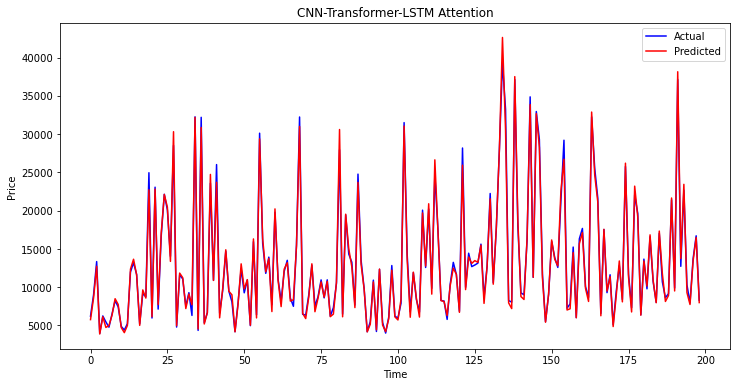

<Figure size 432x288 with 0 Axes>

In [36]:
# Flatten the denormalized_test_Y and denormalized_predictions arrays
denormalized_test_Y_flattened = denormalized_test_Y.flatten()
denormalized_predictions_flattened = denormalized_predictions.flatten()

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(denormalized_test_Y_flattened, label='Actual', color='blue')
plt.plot(denormalized_predictions_flattened, label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.title('CNN-Transformer-LSTM Attention')
plt.show()
# Save the plot as an image file
plt.savefig('actual_vs_predicted.png', dpi=300, bbox_inches='tight')

In [16]:
param_grid = {
    'head_size': [64, 128, 256],
    'num_heads': [2, 4, 8],
    'ff_dim': [128, 256, 512]
}

results = []

for head_size in param_grid['head_size']:
    for num_heads in param_grid['num_heads']:
        for ff_dim in param_grid['ff_dim']:
            
            inputs = Input(shape=(1, 100, 1))
            x = TimeDistributed(Conv1D(64, kernel_size=5, activation='relu'))(inputs)
            x = TimeDistributed(MaxPooling1D(2))(x)
            x = TimeDistributed(Conv1D(128, kernel_size=5, activation='relu'))(x)
            x = TimeDistributed(MaxPooling1D(2))(x)
            x = TimeDistributed(Conv1D(64, kernel_size=5, activation='relu'))(x)
            x = TimeDistributed(MaxPooling1D(2))(x)
            x = TimeDistributed(Flatten())(x)

            # Transformer encoder layer
            x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=0.1)
            x = Bidirectional(LSTM(100, return_sequences=True))(x)
            x = Attention()([x, x])
            x = Dropout(0.3)(x)
            x = Bidirectional(LSTM(100, return_sequences=False))(x)
            x = Dropout(0.3)(x)

            outputs = Dense(1, activation='linear')(x)
            model = tf.keras.Model(inputs=inputs, outputs=outputs)
            model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
            
            model.fit(train_X, train_Y, validation_data=(test_X, test_Y), epochs=100, batch_size=32, verbose=1, shuffle=True)
            
            yhat_probs = model.predict(test_X, verbose=0)
            yhat_probs = yhat_probs[:, 0]

            mae = mean_absolute_error(test_Y.reshape(-1, 1), yhat_probs)
            rmse = np.sqrt(mean_squared_error(test_Y.reshape(-1, 1), yhat_probs))
            
            results.append({
                'head_size': head_size,
                'num_heads': num_heads,
                'ff_dim': ff_dim,
                'MAE': mae,
                'RMSE': rmse
            })

# Convert results to DataFrame for better visualization
df_results = pd.DataFrame(results)
print(df_results)


Epoch 1/100
25/25 [==============================] - 18s 166ms/step - loss: 0.1264 - mse: 0.1264 - mae: 0.2391 - val_loss: 0.0499 - val_mse: 0.0499 - val_mae: 0.1720
Epoch 2/100
25/25 [==============================] - 1s 36ms/step - loss: 0.1179 - mse: 0.1179 - mae: 0.2310 - val_loss: 0.0814 - val_mse: 0.0814 - val_mae: 0.2253
Epoch 3/100
25/25 [==============================] - 1s 36ms/step - loss: 0.0579 - mse: 0.0579 - mae: 0.1775 - val_loss: 0.0773 - val_mse: 0.0773 - val_mae: 0.1718
Epoch 4/100
25/25 [==============================] - 1s 36ms/step - loss: 0.0435 - mse: 0.0435 - mae: 0.1472 - val_loss: 0.0235 - val_mse: 0.0235 - val_mae: 0.1179
Epoch 5/100
25/25 [==============================] - 1s 35ms/step - loss: 0.0495 - mse: 0.0495 - mae: 0.1508 - val_loss: 0.0169 - val_mse: 0.0169 - val_mae: 0.0969
Epoch 6/100
25/25 [==============================] - 1s 37ms/step - loss: 0.0348 - mse: 0.0348 - mae: 0.1270 - val_loss: 0.0843 - val_mse: 0.0843 - val_mae: 0.1808
Epoch 7/100
25

Epoch 51/100
25/25 [==============================] - 1s 38ms/step - loss: 0.0125 - mse: 0.0125 - mae: 0.0725 - val_loss: 0.0079 - val_mse: 0.0079 - val_mae: 0.0641
Epoch 52/100
25/25 [==============================] - 1s 36ms/step - loss: 0.0092 - mse: 0.0092 - mae: 0.0651 - val_loss: 0.0057 - val_mse: 0.0057 - val_mae: 0.0518
Epoch 53/100
25/25 [==============================] - 1s 37ms/step - loss: 0.0127 - mse: 0.0127 - mae: 0.0716 - val_loss: 0.0066 - val_mse: 0.0066 - val_mae: 0.0581
Epoch 54/100
25/25 [==============================] - 1s 38ms/step - loss: 0.0132 - mse: 0.0132 - mae: 0.0774 - val_loss: 0.0143 - val_mse: 0.0143 - val_mae: 0.0810
Epoch 55/100
25/25 [==============================] - 1s 36ms/step - loss: 0.0105 - mse: 0.0105 - mae: 0.0726 - val_loss: 0.0117 - val_mse: 0.0117 - val_mae: 0.0729
Epoch 56/100
25/25 [==============================] - 1s 38ms/step - loss: 0.0120 - mse: 0.0120 - mae: 0.0764 - val_loss: 0.0057 - val_mse: 0.0057 - val_mae: 0.0546
Epoch 57/1

Epoch 1/100
25/25 [==============================] - 19s 167ms/step - loss: 0.1401 - mse: 0.1401 - mae: 0.2511 - val_loss: 0.0481 - val_mse: 0.0481 - val_mae: 0.1721
Epoch 2/100
25/25 [==============================] - 1s 46ms/step - loss: 0.0573 - mse: 0.0573 - mae: 0.1706 - val_loss: 0.0389 - val_mse: 0.0389 - val_mae: 0.1549
Epoch 3/100
25/25 [==============================] - 1s 40ms/step - loss: 0.0553 - mse: 0.0553 - mae: 0.1686 - val_loss: 0.0538 - val_mse: 0.0538 - val_mae: 0.1547
Epoch 4/100
25/25 [==============================] - 1s 45ms/step - loss: 0.0452 - mse: 0.0452 - mae: 0.1434 - val_loss: 0.0207 - val_mse: 0.0207 - val_mae: 0.1071
Epoch 5/100
25/25 [==============================] - 1s 47ms/step - loss: 0.0386 - mse: 0.0386 - mae: 0.1394 - val_loss: 0.0346 - val_mse: 0.0346 - val_mae: 0.1493
Epoch 6/100
25/25 [==============================] - 1s 47ms/step - loss: 0.0327 - mse: 0.0327 - mae: 0.1268 - val_loss: 0.0396 - val_mse: 0.0396 - val_mae: 0.1342
Epoch 7/100
25

Epoch 51/100
25/25 [==============================] - 1s 50ms/step - loss: 0.0106 - mse: 0.0106 - mae: 0.0709 - val_loss: 0.0061 - val_mse: 0.0061 - val_mae: 0.0572
Epoch 52/100
25/25 [==============================] - 1s 50ms/step - loss: 0.0113 - mse: 0.0113 - mae: 0.0732 - val_loss: 0.0069 - val_mse: 0.0069 - val_mae: 0.0598
Epoch 53/100
25/25 [==============================] - 1s 50ms/step - loss: 0.0121 - mse: 0.0121 - mae: 0.0677 - val_loss: 0.0048 - val_mse: 0.0048 - val_mae: 0.0479
Epoch 54/100
25/25 [==============================] - 1s 47ms/step - loss: 0.0119 - mse: 0.0119 - mae: 0.0709 - val_loss: 0.0095 - val_mse: 0.0095 - val_mae: 0.0663
Epoch 55/100
25/25 [==============================] - 1s 46ms/step - loss: 0.0089 - mse: 0.0089 - mae: 0.0644 - val_loss: 0.0094 - val_mse: 0.0094 - val_mae: 0.0707
Epoch 56/100
25/25 [==============================] - 1s 47ms/step - loss: 0.0107 - mse: 0.0107 - mae: 0.0715 - val_loss: 0.0064 - val_mse: 0.0064 - val_mae: 0.0564
Epoch 57/1

Epoch 1/100
25/25 [==============================] - 17s 144ms/step - loss: 0.1861 - mse: 0.1861 - mae: 0.2867 - val_loss: 0.0494 - val_mse: 0.0494 - val_mae: 0.1667
Epoch 2/100
25/25 [==============================] - 1s 43ms/step - loss: 0.0620 - mse: 0.0620 - mae: 0.1784 - val_loss: 0.0353 - val_mse: 0.0353 - val_mae: 0.1397
Epoch 3/100
25/25 [==============================] - 1s 53ms/step - loss: 0.0455 - mse: 0.0455 - mae: 0.1510 - val_loss: 0.0260 - val_mse: 0.0260 - val_mae: 0.1191
Epoch 4/100
25/25 [==============================] - 1s 45ms/step - loss: 0.0433 - mse: 0.0433 - mae: 0.1452 - val_loss: 0.0643 - val_mse: 0.0643 - val_mae: 0.1618
Epoch 5/100
25/25 [==============================] - 1s 47ms/step - loss: 0.0425 - mse: 0.0425 - mae: 0.1417 - val_loss: 0.0304 - val_mse: 0.0304 - val_mae: 0.1229
Epoch 6/100
25/25 [==============================] - 1s 47ms/step - loss: 0.0419 - mse: 0.0419 - mae: 0.1344 - val_loss: 0.0149 - val_mse: 0.0149 - val_mae: 0.0970
Epoch 7/100
25

Epoch 51/100
25/25 [==============================] - 1s 51ms/step - loss: 0.0111 - mse: 0.0111 - mae: 0.0731 - val_loss: 0.0113 - val_mse: 0.0113 - val_mae: 0.0744
Epoch 52/100
25/25 [==============================] - 1s 53ms/step - loss: 0.0111 - mse: 0.0111 - mae: 0.0731 - val_loss: 0.0072 - val_mse: 0.0072 - val_mae: 0.0645
Epoch 53/100
25/25 [==============================] - 1s 50ms/step - loss: 0.0110 - mse: 0.0110 - mae: 0.0683 - val_loss: 0.0055 - val_mse: 0.0055 - val_mae: 0.0508
Epoch 54/100
25/25 [==============================] - 1s 48ms/step - loss: 0.0126 - mse: 0.0126 - mae: 0.0710 - val_loss: 0.0071 - val_mse: 0.0071 - val_mae: 0.0661
Epoch 55/100
25/25 [==============================] - 2s 61ms/step - loss: 0.0134 - mse: 0.0134 - mae: 0.0745 - val_loss: 0.0078 - val_mse: 0.0078 - val_mae: 0.0604
Epoch 56/100
25/25 [==============================] - 1s 48ms/step - loss: 0.0124 - mse: 0.0124 - mae: 0.0738 - val_loss: 0.0090 - val_mse: 0.0090 - val_mae: 0.0634
Epoch 57/1

Epoch 1/100
25/25 [==============================] - 17s 131ms/step - loss: 0.1393 - mse: 0.1393 - mae: 0.2486 - val_loss: 0.0541 - val_mse: 0.0541 - val_mae: 0.1686
Epoch 2/100
25/25 [==============================] - 1s 43ms/step - loss: 0.0619 - mse: 0.0619 - mae: 0.1748 - val_loss: 0.0576 - val_mse: 0.0576 - val_mae: 0.1674
Epoch 3/100
25/25 [==============================] - 1s 47ms/step - loss: 0.0441 - mse: 0.0441 - mae: 0.1434 - val_loss: 0.0705 - val_mse: 0.0705 - val_mae: 0.1565
Epoch 4/100
25/25 [==============================] - 1s 49ms/step - loss: 0.0440 - mse: 0.0440 - mae: 0.1401 - val_loss: 0.0300 - val_mse: 0.0300 - val_mae: 0.1199
Epoch 5/100
25/25 [==============================] - 1s 48ms/step - loss: 0.0296 - mse: 0.0296 - mae: 0.1168 - val_loss: 0.0492 - val_mse: 0.0492 - val_mae: 0.1340
Epoch 6/100
25/25 [==============================] - 1s 48ms/step - loss: 0.0384 - mse: 0.0384 - mae: 0.1273 - val_loss: 0.0248 - val_mse: 0.0248 - val_mae: 0.1268
Epoch 7/100
25

Epoch 51/100
25/25 [==============================] - 1s 53ms/step - loss: 0.0118 - mse: 0.0118 - mae: 0.0773 - val_loss: 0.0063 - val_mse: 0.0063 - val_mae: 0.0575
Epoch 52/100
25/25 [==============================] - 1s 51ms/step - loss: 0.0136 - mse: 0.0136 - mae: 0.0770 - val_loss: 0.0063 - val_mse: 0.0063 - val_mae: 0.0579
Epoch 53/100
25/25 [==============================] - 1s 50ms/step - loss: 0.0125 - mse: 0.0125 - mae: 0.0752 - val_loss: 0.0091 - val_mse: 0.0091 - val_mae: 0.0733
Epoch 54/100
25/25 [==============================] - 1s 49ms/step - loss: 0.0103 - mse: 0.0103 - mae: 0.0693 - val_loss: 0.0074 - val_mse: 0.0074 - val_mae: 0.0602
Epoch 55/100
25/25 [==============================] - 1s 47ms/step - loss: 0.0131 - mse: 0.0131 - mae: 0.0804 - val_loss: 0.0056 - val_mse: 0.0056 - val_mae: 0.0599
Epoch 56/100
25/25 [==============================] - 1s 48ms/step - loss: 0.0113 - mse: 0.0113 - mae: 0.0757 - val_loss: 0.0070 - val_mse: 0.0070 - val_mae: 0.0561
Epoch 57/1

Epoch 1/100
25/25 [==============================] - 17s 141ms/step - loss: 0.1603 - mse: 0.1603 - mae: 0.2620 - val_loss: 0.0916 - val_mse: 0.0916 - val_mae: 0.2135
Epoch 2/100
25/25 [==============================] - 1s 50ms/step - loss: 0.0560 - mse: 0.0560 - mae: 0.1766 - val_loss: 0.0361 - val_mse: 0.0361 - val_mae: 0.1481
Epoch 3/100
25/25 [==============================] - 1s 58ms/step - loss: 0.0469 - mse: 0.0469 - mae: 0.1539 - val_loss: 0.0265 - val_mse: 0.0265 - val_mae: 0.1199
Epoch 4/100
25/25 [==============================] - 1s 52ms/step - loss: 0.0414 - mse: 0.0414 - mae: 0.1343 - val_loss: 0.0426 - val_mse: 0.0426 - val_mae: 0.1415
Epoch 5/100
25/25 [==============================] - 1s 53ms/step - loss: 0.0398 - mse: 0.0398 - mae: 0.1335 - val_loss: 0.0226 - val_mse: 0.0226 - val_mae: 0.1096
Epoch 6/100
25/25 [==============================] - 1s 53ms/step - loss: 0.0373 - mse: 0.0373 - mae: 0.1367 - val_loss: 0.0277 - val_mse: 0.0277 - val_mae: 0.1113
Epoch 7/100
25

Epoch 51/100
25/25 [==============================] - 1s 50ms/step - loss: 0.0130 - mse: 0.0130 - mae: 0.0781 - val_loss: 0.0062 - val_mse: 0.0062 - val_mae: 0.0617
Epoch 52/100
25/25 [==============================] - 2s 62ms/step - loss: 0.0130 - mse: 0.0130 - mae: 0.0743 - val_loss: 0.0090 - val_mse: 0.0090 - val_mae: 0.0697
Epoch 53/100
25/25 [==============================] - 2s 61ms/step - loss: 0.0133 - mse: 0.0133 - mae: 0.0747 - val_loss: 0.0145 - val_mse: 0.0145 - val_mae: 0.0824
Epoch 54/100
25/25 [==============================] - 1s 51ms/step - loss: 0.0127 - mse: 0.0127 - mae: 0.0771 - val_loss: 0.0054 - val_mse: 0.0054 - val_mae: 0.0553
Epoch 55/100
25/25 [==============================] - 1s 56ms/step - loss: 0.0130 - mse: 0.0130 - mae: 0.0765 - val_loss: 0.0065 - val_mse: 0.0065 - val_mae: 0.0585
Epoch 56/100
25/25 [==============================] - 2s 65ms/step - loss: 0.0092 - mse: 0.0092 - mae: 0.0668 - val_loss: 0.0066 - val_mse: 0.0066 - val_mae: 0.0580
Epoch 57/1

Epoch 1/100
25/25 [==============================] - 19s 202ms/step - loss: 0.1794 - mse: 0.1794 - mae: 0.2781 - val_loss: 0.0505 - val_mse: 0.0505 - val_mae: 0.1761
Epoch 2/100
25/25 [==============================] - 2s 71ms/step - loss: 0.0860 - mse: 0.0860 - mae: 0.2071 - val_loss: 0.0612 - val_mse: 0.0612 - val_mae: 0.1877
Epoch 3/100
25/25 [==============================] - 2s 76ms/step - loss: 0.0446 - mse: 0.0446 - mae: 0.1559 - val_loss: 0.0432 - val_mse: 0.0432 - val_mae: 0.1628
Epoch 4/100
25/25 [==============================] - 2s 76ms/step - loss: 0.0406 - mse: 0.0406 - mae: 0.1433 - val_loss: 0.0222 - val_mse: 0.0222 - val_mae: 0.1036
Epoch 5/100
25/25 [==============================] - 2s 74ms/step - loss: 0.0350 - mse: 0.0350 - mae: 0.1319 - val_loss: 0.0319 - val_mse: 0.0319 - val_mae: 0.1204
Epoch 6/100
25/25 [==============================] - 2s 77ms/step - loss: 0.0316 - mse: 0.0316 - mae: 0.1198 - val_loss: 0.0401 - val_mse: 0.0401 - val_mae: 0.1237
Epoch 7/100
25

Epoch 51/100
25/25 [==============================] - 2s 73ms/step - loss: 0.0129 - mse: 0.0129 - mae: 0.0781 - val_loss: 0.0090 - val_mse: 0.0090 - val_mae: 0.0704
Epoch 52/100
25/25 [==============================] - 2s 76ms/step - loss: 0.0129 - mse: 0.0129 - mae: 0.0776 - val_loss: 0.0127 - val_mse: 0.0127 - val_mae: 0.0839
Epoch 53/100
25/25 [==============================] - 2s 75ms/step - loss: 0.0132 - mse: 0.0132 - mae: 0.0762 - val_loss: 0.0075 - val_mse: 0.0075 - val_mae: 0.0589
Epoch 54/100
25/25 [==============================] - 2s 78ms/step - loss: 0.0133 - mse: 0.0133 - mae: 0.0753 - val_loss: 0.0103 - val_mse: 0.0103 - val_mae: 0.0668
Epoch 55/100
25/25 [==============================] - 2s 80ms/step - loss: 0.0125 - mse: 0.0125 - mae: 0.0720 - val_loss: 0.0074 - val_mse: 0.0074 - val_mae: 0.0568
Epoch 56/100
25/25 [==============================] - 2s 81ms/step - loss: 0.0104 - mse: 0.0104 - mae: 0.0694 - val_loss: 0.0086 - val_mse: 0.0086 - val_mae: 0.0662
Epoch 57/1

Epoch 1/100
25/25 [==============================] - 20s 213ms/step - loss: 0.1447 - mse: 0.1447 - mae: 0.2626 - val_loss: 0.0767 - val_mse: 0.0767 - val_mae: 0.1969
Epoch 2/100
25/25 [==============================] - 2s 73ms/step - loss: 0.0859 - mse: 0.0859 - mae: 0.1975 - val_loss: 0.0483 - val_mse: 0.0483 - val_mae: 0.1526
Epoch 3/100
25/25 [==============================] - 2s 76ms/step - loss: 0.0570 - mse: 0.0570 - mae: 0.1727 - val_loss: 0.0234 - val_mse: 0.0234 - val_mae: 0.1191
Epoch 4/100
25/25 [==============================] - 2s 78ms/step - loss: 0.0403 - mse: 0.0403 - mae: 0.1457 - val_loss: 0.0264 - val_mse: 0.0264 - val_mae: 0.1261
Epoch 5/100
25/25 [==============================] - 2s 76ms/step - loss: 0.0364 - mse: 0.0364 - mae: 0.1250 - val_loss: 0.0456 - val_mse: 0.0456 - val_mae: 0.1372
Epoch 6/100
25/25 [==============================] - 2s 76ms/step - loss: 0.0370 - mse: 0.0370 - mae: 0.1296 - val_loss: 0.0231 - val_mse: 0.0231 - val_mae: 0.1185
Epoch 7/100
25

Epoch 51/100
25/25 [==============================] - 2s 82ms/step - loss: 0.0130 - mse: 0.0130 - mae: 0.0823 - val_loss: 0.0106 - val_mse: 0.0106 - val_mae: 0.0837
Epoch 52/100
25/25 [==============================] - 2s 78ms/step - loss: 0.0150 - mse: 0.0150 - mae: 0.0860 - val_loss: 0.0081 - val_mse: 0.0081 - val_mae: 0.0727
Epoch 53/100
25/25 [==============================] - 2s 75ms/step - loss: 0.0122 - mse: 0.0122 - mae: 0.0820 - val_loss: 0.0092 - val_mse: 0.0092 - val_mae: 0.0745
Epoch 54/100
25/25 [==============================] - 2s 76ms/step - loss: 0.0110 - mse: 0.0110 - mae: 0.0707 - val_loss: 0.0079 - val_mse: 0.0079 - val_mae: 0.0584
Epoch 55/100
25/25 [==============================] - 2s 75ms/step - loss: 0.0130 - mse: 0.0130 - mae: 0.0750 - val_loss: 0.0203 - val_mse: 0.0203 - val_mae: 0.0886
Epoch 56/100
25/25 [==============================] - 2s 79ms/step - loss: 0.0125 - mse: 0.0125 - mae: 0.0758 - val_loss: 0.0068 - val_mse: 0.0068 - val_mae: 0.0627
Epoch 57/1

Epoch 1/100
25/25 [==============================] - 20s 217ms/step - loss: 0.1716 - mse: 0.1716 - mae: 0.2754 - val_loss: 0.0486 - val_mse: 0.0486 - val_mae: 0.1708
Epoch 2/100
25/25 [==============================] - 2s 82ms/step - loss: 0.0783 - mse: 0.0783 - mae: 0.2025 - val_loss: 0.0316 - val_mse: 0.0316 - val_mae: 0.1388
Epoch 3/100
25/25 [==============================] - 2s 79ms/step - loss: 0.0483 - mse: 0.0483 - mae: 0.1576 - val_loss: 0.0257 - val_mse: 0.0257 - val_mae: 0.1205
Epoch 4/100
25/25 [==============================] - 2s 76ms/step - loss: 0.0426 - mse: 0.0426 - mae: 0.1410 - val_loss: 0.0318 - val_mse: 0.0318 - val_mae: 0.1375
Epoch 5/100
25/25 [==============================] - 2s 76ms/step - loss: 0.0380 - mse: 0.0380 - mae: 0.1380 - val_loss: 0.0241 - val_mse: 0.0241 - val_mae: 0.1134
Epoch 6/100
25/25 [==============================] - 2s 77ms/step - loss: 0.0373 - mse: 0.0373 - mae: 0.1288 - val_loss: 0.0165 - val_mse: 0.0165 - val_mae: 0.0937
Epoch 7/100
25

Epoch 51/100
25/25 [==============================] - 2s 83ms/step - loss: 0.0214 - mse: 0.0214 - mae: 0.1059 - val_loss: 0.0154 - val_mse: 0.0154 - val_mae: 0.0954
Epoch 52/100
25/25 [==============================] - 2s 80ms/step - loss: 0.0153 - mse: 0.0153 - mae: 0.0844 - val_loss: 0.0171 - val_mse: 0.0171 - val_mae: 0.0927
Epoch 53/100
25/25 [==============================] - 2s 76ms/step - loss: 0.0184 - mse: 0.0184 - mae: 0.0902 - val_loss: 0.0288 - val_mse: 0.0288 - val_mae: 0.1182
Epoch 54/100
25/25 [==============================] - 2s 75ms/step - loss: 0.0226 - mse: 0.0226 - mae: 0.1093 - val_loss: 0.0222 - val_mse: 0.0222 - val_mae: 0.1161
Epoch 55/100
25/25 [==============================] - 2s 76ms/step - loss: 0.0168 - mse: 0.0168 - mae: 0.0905 - val_loss: 0.0082 - val_mse: 0.0082 - val_mae: 0.0629
Epoch 56/100
25/25 [==============================] - 2s 84ms/step - loss: 0.0097 - mse: 0.0097 - mae: 0.0670 - val_loss: 0.0049 - val_mse: 0.0049 - val_mae: 0.0500
Epoch 57/1

Epoch 1/100
25/25 [==============================] - 26s 472ms/step - loss: 0.1892 - mse: 0.1892 - mae: 0.2862 - val_loss: 0.1242 - val_mse: 0.1242 - val_mae: 0.2712
Epoch 2/100
25/25 [==============================] - 7s 274ms/step - loss: 0.0731 - mse: 0.0731 - mae: 0.1881 - val_loss: 0.0323 - val_mse: 0.0323 - val_mae: 0.1201
Epoch 3/100
25/25 [==============================] - 5s 198ms/step - loss: 0.0481 - mse: 0.0481 - mae: 0.1565 - val_loss: 0.0306 - val_mse: 0.0306 - val_mae: 0.1284
Epoch 4/100
25/25 [==============================] - 3s 113ms/step - loss: 0.0416 - mse: 0.0416 - mae: 0.1482 - val_loss: 0.0212 - val_mse: 0.0212 - val_mae: 0.1125
Epoch 5/100
25/25 [==============================] - 2s 99ms/step - loss: 0.0362 - mse: 0.0362 - mae: 0.1222 - val_loss: 0.0348 - val_mse: 0.0348 - val_mae: 0.1280
Epoch 6/100
25/25 [==============================] - 3s 135ms/step - loss: 0.0267 - mse: 0.0267 - mae: 0.1112 - val_loss: 0.0201 - val_mse: 0.0201 - val_mae: 0.0993
Epoch 7/10

Epoch 100/100
25/25 [==============================] - 2s 83ms/step - loss: 0.0073 - mse: 0.0073 - mae: 0.0586 - val_loss: 0.0053 - val_mse: 0.0053 - val_mae: 0.0505
Epoch 1/100
25/25 [==============================] - 21s 175ms/step - loss: 0.1888 - mse: 0.1888 - mae: 0.2879 - val_loss: 0.0368 - val_mse: 0.0368 - val_mae: 0.1411
Epoch 2/100
25/25 [==============================] - 2s 60ms/step - loss: 0.0677 - mse: 0.0677 - mae: 0.1843 - val_loss: 0.0330 - val_mse: 0.0330 - val_mae: 0.1361
Epoch 3/100
25/25 [==============================] - 2s 78ms/step - loss: 0.0434 - mse: 0.0434 - mae: 0.1469 - val_loss: 0.0245 - val_mse: 0.0245 - val_mae: 0.1117
Epoch 4/100
25/25 [==============================] - 1s 59ms/step - loss: 0.0364 - mse: 0.0364 - mae: 0.1292 - val_loss: 0.0189 - val_mse: 0.0189 - val_mae: 0.0959
Epoch 5/100
25/25 [==============================] - 1s 60ms/step - loss: 0.0323 - mse: 0.0323 - mae: 0.1199 - val_loss: 0.0171 - val_mse: 0.0171 - val_mae: 0.0879
Epoch 6/100


Epoch 50/100
25/25 [==============================] - 2s 62ms/step - loss: 0.0131 - mse: 0.0131 - mae: 0.0766 - val_loss: 0.0093 - val_mse: 0.0093 - val_mae: 0.0747
Epoch 51/100
25/25 [==============================] - 2s 61ms/step - loss: 0.0157 - mse: 0.0157 - mae: 0.0844 - val_loss: 0.0134 - val_mse: 0.0134 - val_mae: 0.0878
Epoch 52/100
25/25 [==============================] - 2s 60ms/step - loss: 0.0165 - mse: 0.0165 - mae: 0.0810 - val_loss: 0.0096 - val_mse: 0.0096 - val_mae: 0.0747
Epoch 53/100
25/25 [==============================] - 2s 66ms/step - loss: 0.0152 - mse: 0.0152 - mae: 0.0838 - val_loss: 0.0068 - val_mse: 0.0068 - val_mae: 0.0601
Epoch 54/100
25/25 [==============================] - 2s 67ms/step - loss: 0.0122 - mse: 0.0122 - mae: 0.0737 - val_loss: 0.0093 - val_mse: 0.0093 - val_mae: 0.0660
Epoch 55/100
25/25 [==============================] - 1s 57ms/step - loss: 0.0131 - mse: 0.0131 - mae: 0.0814 - val_loss: 0.0229 - val_mse: 0.0229 - val_mae: 0.0946
Epoch 56/1

Epoch 100/100
25/25 [==============================] - 2s 63ms/step - loss: 0.0105 - mse: 0.0105 - mae: 0.0677 - val_loss: 0.0102 - val_mse: 0.0102 - val_mae: 0.0626
Epoch 1/100
25/25 [==============================] - 20s 197ms/step - loss: 0.1782 - mse: 0.1782 - mae: 0.2901 - val_loss: 0.0588 - val_mse: 0.0588 - val_mae: 0.1740
Epoch 2/100
25/25 [==============================] - 2s 63ms/step - loss: 0.0631 - mse: 0.0631 - mae: 0.1743 - val_loss: 0.0344 - val_mse: 0.0344 - val_mae: 0.1244
Epoch 3/100
25/25 [==============================] - 2s 65ms/step - loss: 0.0406 - mse: 0.0406 - mae: 0.1447 - val_loss: 0.0376 - val_mse: 0.0376 - val_mae: 0.1514
Epoch 4/100
25/25 [==============================] - 2s 67ms/step - loss: 0.0356 - mse: 0.0356 - mae: 0.1319 - val_loss: 0.0415 - val_mse: 0.0415 - val_mae: 0.1284
Epoch 5/100
25/25 [==============================] - 2s 70ms/step - loss: 0.0366 - mse: 0.0366 - mae: 0.1311 - val_loss: 0.0206 - val_mse: 0.0206 - val_mae: 0.1084
Epoch 6/100


Epoch 50/100
25/25 [==============================] - 1s 53ms/step - loss: 0.0130 - mse: 0.0130 - mae: 0.0788 - val_loss: 0.0114 - val_mse: 0.0114 - val_mae: 0.0753
Epoch 51/100
25/25 [==============================] - 1s 54ms/step - loss: 0.0130 - mse: 0.0130 - mae: 0.0765 - val_loss: 0.0068 - val_mse: 0.0068 - val_mae: 0.0639
Epoch 52/100
25/25 [==============================] - 1s 58ms/step - loss: 0.0106 - mse: 0.0106 - mae: 0.0681 - val_loss: 0.0077 - val_mse: 0.0077 - val_mae: 0.0602
Epoch 53/100
25/25 [==============================] - 2s 60ms/step - loss: 0.0117 - mse: 0.0117 - mae: 0.0696 - val_loss: 0.0116 - val_mse: 0.0116 - val_mae: 0.0788
Epoch 54/100
25/25 [==============================] - 2s 61ms/step - loss: 0.0111 - mse: 0.0111 - mae: 0.0717 - val_loss: 0.0105 - val_mse: 0.0105 - val_mae: 0.0691
Epoch 55/100
25/25 [==============================] - 2s 75ms/step - loss: 0.0135 - mse: 0.0135 - mae: 0.0759 - val_loss: 0.0085 - val_mse: 0.0085 - val_mae: 0.0703
Epoch 56/1

Epoch 100/100
25/25 [==============================] - 2s 62ms/step - loss: 0.0098 - mse: 0.0098 - mae: 0.0682 - val_loss: 0.0079 - val_mse: 0.0079 - val_mae: 0.0667
Epoch 1/100
25/25 [==============================] - 20s 163ms/step - loss: 0.1667 - mse: 0.1667 - mae: 0.2676 - val_loss: 0.0578 - val_mse: 0.0578 - val_mae: 0.1789
Epoch 2/100
25/25 [==============================] - 2s 61ms/step - loss: 0.0531 - mse: 0.0531 - mae: 0.1726 - val_loss: 0.0603 - val_mse: 0.0603 - val_mae: 0.1712
Epoch 3/100
25/25 [==============================] - 2s 63ms/step - loss: 0.0534 - mse: 0.0534 - mae: 0.1706 - val_loss: 0.0475 - val_mse: 0.0475 - val_mae: 0.1506
Epoch 4/100
25/25 [==============================] - 1s 60ms/step - loss: 0.0412 - mse: 0.0412 - mae: 0.1435 - val_loss: 0.0869 - val_mse: 0.0869 - val_mae: 0.1808
Epoch 5/100
25/25 [==============================] - 1s 58ms/step - loss: 0.0374 - mse: 0.0374 - mae: 0.1365 - val_loss: 0.0369 - val_mse: 0.0369 - val_mae: 0.1456
Epoch 6/100


Epoch 50/100
25/25 [==============================] - 2s 67ms/step - loss: 0.0100 - mse: 0.0100 - mae: 0.0718 - val_loss: 0.0107 - val_mse: 0.0107 - val_mae: 0.0762
Epoch 51/100
25/25 [==============================] - 2s 69ms/step - loss: 0.0144 - mse: 0.0144 - mae: 0.0787 - val_loss: 0.0096 - val_mse: 0.0096 - val_mae: 0.0701
Epoch 52/100
25/25 [==============================] - 2s 79ms/step - loss: 0.0121 - mse: 0.0121 - mae: 0.0743 - val_loss: 0.0147 - val_mse: 0.0147 - val_mae: 0.0848
Epoch 53/100
25/25 [==============================] - 2s 78ms/step - loss: 0.0148 - mse: 0.0148 - mae: 0.0823 - val_loss: 0.0089 - val_mse: 0.0089 - val_mae: 0.0721
Epoch 54/100
25/25 [==============================] - 2s 77ms/step - loss: 0.0164 - mse: 0.0164 - mae: 0.0907 - val_loss: 0.0249 - val_mse: 0.0249 - val_mae: 0.1150
Epoch 55/100
25/25 [==============================] - 2s 76ms/step - loss: 0.0161 - mse: 0.0161 - mae: 0.0891 - val_loss: 0.0098 - val_mse: 0.0098 - val_mae: 0.0694
Epoch 56/1

Epoch 100/100
25/25 [==============================] - 2s 70ms/step - loss: 0.0125 - mse: 0.0125 - mae: 0.0743 - val_loss: 0.0121 - val_mse: 0.0121 - val_mae: 0.0718
Epoch 1/100
25/25 [==============================] - 19s 160ms/step - loss: 0.1827 - mse: 0.1827 - mae: 0.2850 - val_loss: 0.0517 - val_mse: 0.0517 - val_mae: 0.1760
Epoch 2/100
25/25 [==============================] - 2s 71ms/step - loss: 0.0830 - mse: 0.0830 - mae: 0.2046 - val_loss: 0.0884 - val_mse: 0.0884 - val_mae: 0.2144
Epoch 3/100
25/25 [==============================] - 2s 78ms/step - loss: 0.0605 - mse: 0.0605 - mae: 0.1713 - val_loss: 0.0485 - val_mse: 0.0485 - val_mae: 0.1636
Epoch 4/100
25/25 [==============================] - 2s 75ms/step - loss: 0.0501 - mse: 0.0501 - mae: 0.1626 - val_loss: 0.0609 - val_mse: 0.0609 - val_mae: 0.1763
Epoch 5/100
25/25 [==============================] - 2s 78ms/step - loss: 0.0412 - mse: 0.0412 - mae: 0.1368 - val_loss: 0.0177 - val_mse: 0.0177 - val_mae: 0.0924
Epoch 6/100


Epoch 50/100
25/25 [==============================] - 2s 77ms/step - loss: 0.0135 - mse: 0.0135 - mae: 0.0806 - val_loss: 0.0122 - val_mse: 0.0122 - val_mae: 0.0822
Epoch 51/100
25/25 [==============================] - 2s 94ms/step - loss: 0.0107 - mse: 0.0107 - mae: 0.0710 - val_loss: 0.0144 - val_mse: 0.0144 - val_mae: 0.0859
Epoch 52/100
25/25 [==============================] - 2s 88ms/step - loss: 0.0119 - mse: 0.0119 - mae: 0.0741 - val_loss: 0.0118 - val_mse: 0.0118 - val_mae: 0.0743
Epoch 53/100
25/25 [==============================] - 2s 76ms/step - loss: 0.0191 - mse: 0.0191 - mae: 0.0897 - val_loss: 0.0119 - val_mse: 0.0119 - val_mae: 0.0839
Epoch 54/100
25/25 [==============================] - 2s 75ms/step - loss: 0.0145 - mse: 0.0145 - mae: 0.0892 - val_loss: 0.0088 - val_mse: 0.0088 - val_mae: 0.0730
Epoch 55/100
25/25 [==============================] - 2s 70ms/step - loss: 0.0094 - mse: 0.0094 - mae: 0.0701 - val_loss: 0.0080 - val_mse: 0.0080 - val_mae: 0.0692
Epoch 56/1

Epoch 100/100
25/25 [==============================] - 2s 82ms/step - loss: 0.0089 - mse: 0.0089 - mae: 0.0657 - val_loss: 0.0059 - val_mse: 0.0059 - val_mae: 0.0576
Epoch 1/100
25/25 [==============================] - 20s 184ms/step - loss: 0.1342 - mse: 0.1342 - mae: 0.2511 - val_loss: 0.0401 - val_mse: 0.0401 - val_mae: 0.1593
Epoch 2/100
25/25 [==============================] - 2s 75ms/step - loss: 0.0893 - mse: 0.0893 - mae: 0.2051 - val_loss: 0.0422 - val_mse: 0.0422 - val_mae: 0.1508
Epoch 3/100
25/25 [==============================] - 2s 81ms/step - loss: 0.0776 - mse: 0.0776 - mae: 0.1938 - val_loss: 0.0488 - val_mse: 0.0488 - val_mae: 0.1510
Epoch 4/100
25/25 [==============================] - 2s 83ms/step - loss: 0.0609 - mse: 0.0609 - mae: 0.1701 - val_loss: 0.0861 - val_mse: 0.0861 - val_mae: 0.1694
Epoch 5/100
25/25 [==============================] - 2s 82ms/step - loss: 0.0704 - mse: 0.0704 - mae: 0.1728 - val_loss: 0.0368 - val_mse: 0.0368 - val_mae: 0.1241
Epoch 6/100


25/25 [==============================] - 2s 78ms/step - loss: 0.0125 - mse: 0.0125 - mae: 0.0702 - val_loss: 0.0090 - val_mse: 0.0090 - val_mae: 0.0676
Epoch 99/100
25/25 [==============================] - 2s 74ms/step - loss: 0.0095 - mse: 0.0095 - mae: 0.0657 - val_loss: 0.0083 - val_mse: 0.0083 - val_mae: 0.0636
Epoch 100/100
25/25 [==============================] - 2s 76ms/step - loss: 0.0112 - mse: 0.0112 - mae: 0.0690 - val_loss: 0.0054 - val_mse: 0.0054 - val_mae: 0.0544
Epoch 1/100
25/25 [==============================] - 26s 247ms/step - loss: 0.1539 - mse: 0.1539 - mae: 0.2765 - val_loss: 0.0444 - val_mse: 0.0444 - val_mae: 0.1568
Epoch 2/100
25/25 [==============================] - 2s 85ms/step - loss: 0.0700 - mse: 0.0700 - mae: 0.1921 - val_loss: 0.0931 - val_mse: 0.0931 - val_mae: 0.2013
Epoch 3/100
25/25 [==============================] - 3s 103ms/step - loss: 0.0726 - mse: 0.0726 - mae: 0.1846 - val_loss: 0.0335 - val_mse: 0.0335 - val_mae: 0.1407
Epoch 4/100
25/25 [===

Epoch 48/100
25/25 [==============================] - 2s 86ms/step - loss: 0.0137 - mse: 0.0137 - mae: 0.0840 - val_loss: 0.0176 - val_mse: 0.0176 - val_mae: 0.0880
Epoch 49/100
25/25 [==============================] - 2s 89ms/step - loss: 0.0132 - mse: 0.0132 - mae: 0.0766 - val_loss: 0.0053 - val_mse: 0.0053 - val_mae: 0.0573
Epoch 50/100
25/25 [==============================] - 2s 90ms/step - loss: 0.0137 - mse: 0.0137 - mae: 0.0787 - val_loss: 0.0124 - val_mse: 0.0124 - val_mae: 0.0777
Epoch 51/100
25/25 [==============================] - 2s 97ms/step - loss: 0.0119 - mse: 0.0119 - mae: 0.0758 - val_loss: 0.0096 - val_mse: 0.0096 - val_mae: 0.0732
Epoch 52/100
25/25 [==============================] - 2s 83ms/step - loss: 0.0127 - mse: 0.0127 - mae: 0.0764 - val_loss: 0.0067 - val_mse: 0.0067 - val_mae: 0.0616
Epoch 53/100
25/25 [==============================] - 2s 83ms/step - loss: 0.0134 - mse: 0.0134 - mae: 0.0807 - val_loss: 0.0082 - val_mse: 0.0082 - val_mae: 0.0709
Epoch 54/1

25/25 [==============================] - 3s 104ms/step - loss: 0.0167 - mse: 0.0167 - mae: 0.0920 - val_loss: 0.0113 - val_mse: 0.0113 - val_mae: 0.0771
Epoch 47/100
25/25 [==============================] - 3s 107ms/step - loss: 0.0140 - mse: 0.0140 - mae: 0.0811 - val_loss: 0.0086 - val_mse: 0.0086 - val_mae: 0.0602
Epoch 48/100
25/25 [==============================] - 3s 118ms/step - loss: 0.0109 - mse: 0.0109 - mae: 0.0721 - val_loss: 0.0120 - val_mse: 0.0120 - val_mae: 0.0724
Epoch 49/100
25/25 [==============================] - 3s 105ms/step - loss: 0.0107 - mse: 0.0107 - mae: 0.0747 - val_loss: 0.0108 - val_mse: 0.0108 - val_mae: 0.0665
Epoch 50/100
25/25 [==============================] - 3s 103ms/step - loss: 0.0130 - mse: 0.0130 - mae: 0.0760 - val_loss: 0.0185 - val_mse: 0.0185 - val_mae: 0.0921
Epoch 51/100
25/25 [==============================] - 2s 94ms/step - loss: 0.0162 - mse: 0.0162 - mae: 0.0859 - val_loss: 0.0058 - val_mse: 0.0058 - val_mae: 0.0531
Epoch 52/100
25/25

Epoch 45/100
25/25 [==============================] - 3s 110ms/step - loss: 0.0106 - mse: 0.0106 - mae: 0.0714 - val_loss: 0.0091 - val_mse: 0.0091 - val_mae: 0.0669
Epoch 46/100
25/25 [==============================] - 3s 112ms/step - loss: 0.0150 - mse: 0.0150 - mae: 0.0793 - val_loss: 0.0189 - val_mse: 0.0189 - val_mae: 0.0931
Epoch 47/100
25/25 [==============================] - 3s 100ms/step - loss: 0.0142 - mse: 0.0142 - mae: 0.0820 - val_loss: 0.0075 - val_mse: 0.0075 - val_mae: 0.0620
Epoch 48/100
25/25 [==============================] - 3s 107ms/step - loss: 0.0093 - mse: 0.0093 - mae: 0.0678 - val_loss: 0.0113 - val_mse: 0.0113 - val_mae: 0.0679
Epoch 49/100
25/25 [==============================] - 3s 104ms/step - loss: 0.0143 - mse: 0.0143 - mae: 0.0777 - val_loss: 0.0072 - val_mse: 0.0072 - val_mae: 0.0676
Epoch 50/100
25/25 [==============================] - 3s 107ms/step - loss: 0.0127 - mse: 0.0127 - mae: 0.0755 - val_loss: 0.0088 - val_mse: 0.0088 - val_mae: 0.0712
Epoc

25/25 [==============================] - 2s 96ms/step - loss: 0.0143 - mse: 0.0143 - mae: 0.0803 - val_loss: 0.0076 - val_mse: 0.0076 - val_mae: 0.0670
Epoch 44/100
25/25 [==============================] - 2s 93ms/step - loss: 0.0139 - mse: 0.0139 - mae: 0.0821 - val_loss: 0.0118 - val_mse: 0.0118 - val_mae: 0.0851
Epoch 45/100
25/25 [==============================] - 2s 97ms/step - loss: 0.0164 - mse: 0.0164 - mae: 0.0861 - val_loss: 0.0091 - val_mse: 0.0091 - val_mae: 0.0765
Epoch 46/100
25/25 [==============================] - 2s 90ms/step - loss: 0.0149 - mse: 0.0149 - mae: 0.0889 - val_loss: 0.0092 - val_mse: 0.0092 - val_mae: 0.0697
Epoch 47/100
25/25 [==============================] - 2s 88ms/step - loss: 0.0112 - mse: 0.0112 - mae: 0.0750 - val_loss: 0.0098 - val_mse: 0.0098 - val_mae: 0.0759
Epoch 48/100
25/25 [==============================] - 2s 88ms/step - loss: 0.0145 - mse: 0.0145 - mae: 0.0827 - val_loss: 0.0104 - val_mse: 0.0104 - val_mae: 0.0772
Epoch 49/100
25/25 [===

Epoch 42/100
25/25 [==============================] - 2s 68ms/step - loss: 0.0150 - mse: 0.0150 - mae: 0.0842 - val_loss: 0.0089 - val_mse: 0.0089 - val_mae: 0.0640
Epoch 43/100
25/25 [==============================] - 2s 68ms/step - loss: 0.0138 - mse: 0.0138 - mae: 0.0817 - val_loss: 0.0147 - val_mse: 0.0147 - val_mae: 0.0853
Epoch 44/100
25/25 [==============================] - 2s 64ms/step - loss: 0.0143 - mse: 0.0143 - mae: 0.0797 - val_loss: 0.0115 - val_mse: 0.0115 - val_mae: 0.0704
Epoch 45/100
25/25 [==============================] - 2s 63ms/step - loss: 0.0156 - mse: 0.0156 - mae: 0.0840 - val_loss: 0.0148 - val_mse: 0.0148 - val_mae: 0.0964
Epoch 46/100
25/25 [==============================] - 2s 63ms/step - loss: 0.0159 - mse: 0.0159 - mae: 0.0845 - val_loss: 0.0152 - val_mse: 0.0152 - val_mae: 0.0919
Epoch 47/100
25/25 [==============================] - 2s 63ms/step - loss: 0.0133 - mse: 0.0133 - mae: 0.0776 - val_loss: 0.0089 - val_mse: 0.0089 - val_mae: 0.0637
Epoch 48/1

Epoch 92/100
25/25 [==============================] - 2s 85ms/step - loss: 0.0114 - mse: 0.0114 - mae: 0.0709 - val_loss: 0.0064 - val_mse: 0.0064 - val_mae: 0.0644
Epoch 93/100
25/25 [==============================] - 2s 80ms/step - loss: 0.0097 - mse: 0.0097 - mae: 0.0648 - val_loss: 0.0080 - val_mse: 0.0080 - val_mae: 0.0600
Epoch 94/100
25/25 [==============================] - 2s 83ms/step - loss: 0.0101 - mse: 0.0101 - mae: 0.0663 - val_loss: 0.0064 - val_mse: 0.0064 - val_mae: 0.0533
Epoch 95/100
25/25 [==============================] - 2s 79ms/step - loss: 0.0083 - mse: 0.0083 - mae: 0.0638 - val_loss: 0.0107 - val_mse: 0.0107 - val_mae: 0.0707
Epoch 96/100
25/25 [==============================] - 2s 84ms/step - loss: 0.0101 - mse: 0.0101 - mae: 0.0663 - val_loss: 0.0075 - val_mse: 0.0075 - val_mae: 0.0578
Epoch 97/100
25/25 [==============================] - 2s 91ms/step - loss: 0.0106 - mse: 0.0106 - mae: 0.0695 - val_loss: 0.0064 - val_mse: 0.0064 - val_mae: 0.0550
Epoch 98/1

Epoch 42/100
25/25 [==============================] - 2s 72ms/step - loss: 0.0168 - mse: 0.0168 - mae: 0.0960 - val_loss: 0.0133 - val_mse: 0.0133 - val_mae: 0.0908
Epoch 43/100
25/25 [==============================] - 2s 72ms/step - loss: 0.0182 - mse: 0.0182 - mae: 0.0911 - val_loss: 0.0344 - val_mse: 0.0344 - val_mae: 0.1226
Epoch 44/100
25/25 [==============================] - 2s 67ms/step - loss: 0.0183 - mse: 0.0183 - mae: 0.0929 - val_loss: 0.0096 - val_mse: 0.0096 - val_mae: 0.0759
Epoch 45/100
25/25 [==============================] - 2s 65ms/step - loss: 0.0143 - mse: 0.0143 - mae: 0.0803 - val_loss: 0.0064 - val_mse: 0.0064 - val_mae: 0.0543
Epoch 46/100
25/25 [==============================] - 2s 66ms/step - loss: 0.0113 - mse: 0.0113 - mae: 0.0744 - val_loss: 0.0066 - val_mse: 0.0066 - val_mae: 0.0610
Epoch 47/100
25/25 [==============================] - 2s 78ms/step - loss: 0.0125 - mse: 0.0125 - mae: 0.0805 - val_loss: 0.0085 - val_mse: 0.0085 - val_mae: 0.0743
Epoch 48/1

Epoch 92/100
25/25 [==============================] - 2s 63ms/step - loss: 0.0217 - mse: 0.0217 - mae: 0.1057 - val_loss: 0.0211 - val_mse: 0.0211 - val_mae: 0.1082
Epoch 93/100
25/25 [==============================] - 2s 66ms/step - loss: 0.0231 - mse: 0.0231 - mae: 0.1076 - val_loss: 0.0147 - val_mse: 0.0147 - val_mae: 0.0874
Epoch 94/100
25/25 [==============================] - 2s 68ms/step - loss: 0.0198 - mse: 0.0198 - mae: 0.0930 - val_loss: 0.0172 - val_mse: 0.0172 - val_mae: 0.1008
Epoch 95/100
25/25 [==============================] - 2s 70ms/step - loss: 0.0227 - mse: 0.0227 - mae: 0.1031 - val_loss: 0.0110 - val_mse: 0.0110 - val_mae: 0.0827
Epoch 96/100
25/25 [==============================] - 2s 70ms/step - loss: 0.0201 - mse: 0.0201 - mae: 0.0926 - val_loss: 0.0143 - val_mse: 0.0143 - val_mae: 0.0872
Epoch 97/100
25/25 [==============================] - 2s 72ms/step - loss: 0.0172 - mse: 0.0172 - mae: 0.0880 - val_loss: 0.0087 - val_mse: 0.0087 - val_mae: 0.0654
Epoch 98/1

Epoch 42/100
25/25 [==============================] - 2s 78ms/step - loss: 0.0144 - mse: 0.0144 - mae: 0.0791 - val_loss: 0.0123 - val_mse: 0.0123 - val_mae: 0.0714
Epoch 43/100
25/25 [==============================] - 2s 80ms/step - loss: 0.0155 - mse: 0.0155 - mae: 0.0811 - val_loss: 0.0085 - val_mse: 0.0085 - val_mae: 0.0744
Epoch 44/100
25/25 [==============================] - 2s 84ms/step - loss: 0.0159 - mse: 0.0159 - mae: 0.0827 - val_loss: 0.0156 - val_mse: 0.0156 - val_mae: 0.0765
Epoch 45/100
25/25 [==============================] - 2s 84ms/step - loss: 0.0167 - mse: 0.0167 - mae: 0.0839 - val_loss: 0.0259 - val_mse: 0.0259 - val_mae: 0.1175
Epoch 46/100
25/25 [==============================] - 2s 88ms/step - loss: 0.0209 - mse: 0.0209 - mae: 0.1005 - val_loss: 0.0094 - val_mse: 0.0094 - val_mae: 0.0722
Epoch 47/100
25/25 [==============================] - 2s 84ms/step - loss: 0.0117 - mse: 0.0117 - mae: 0.0771 - val_loss: 0.0099 - val_mse: 0.0099 - val_mae: 0.0713
Epoch 48/1

Epoch 92/100
25/25 [==============================] - 2s 79ms/step - loss: 0.0130 - mse: 0.0130 - mae: 0.0791 - val_loss: 0.0081 - val_mse: 0.0081 - val_mae: 0.0652
Epoch 93/100
25/25 [==============================] - 2s 77ms/step - loss: 0.0148 - mse: 0.0148 - mae: 0.0889 - val_loss: 0.0057 - val_mse: 0.0057 - val_mae: 0.0572
Epoch 94/100
25/25 [==============================] - 2s 77ms/step - loss: 0.0123 - mse: 0.0123 - mae: 0.0772 - val_loss: 0.0057 - val_mse: 0.0057 - val_mae: 0.0566
Epoch 95/100
25/25 [==============================] - 2s 83ms/step - loss: 0.0120 - mse: 0.0120 - mae: 0.0751 - val_loss: 0.0094 - val_mse: 0.0094 - val_mae: 0.0655
Epoch 96/100
25/25 [==============================] - 2s 78ms/step - loss: 0.0131 - mse: 0.0131 - mae: 0.0782 - val_loss: 0.0084 - val_mse: 0.0084 - val_mae: 0.0738
Epoch 97/100
25/25 [==============================] - 2s 73ms/step - loss: 0.0113 - mse: 0.0113 - mae: 0.0752 - val_loss: 0.0089 - val_mse: 0.0089 - val_mae: 0.0658
Epoch 98/1

Epoch 42/100
25/25 [==============================] - 2s 91ms/step - loss: 0.0119 - mse: 0.0119 - mae: 0.0730 - val_loss: 0.0068 - val_mse: 0.0068 - val_mae: 0.0595
Epoch 43/100
25/25 [==============================] - 2s 85ms/step - loss: 0.0105 - mse: 0.0105 - mae: 0.0683 - val_loss: 0.0100 - val_mse: 0.0100 - val_mae: 0.0659
Epoch 44/100
25/25 [==============================] - 2s 84ms/step - loss: 0.0111 - mse: 0.0111 - mae: 0.0720 - val_loss: 0.0117 - val_mse: 0.0117 - val_mae: 0.0769
Epoch 45/100
25/25 [==============================] - 2s 93ms/step - loss: 0.0136 - mse: 0.0136 - mae: 0.0810 - val_loss: 0.0121 - val_mse: 0.0121 - val_mae: 0.0782
Epoch 46/100
25/25 [==============================] - 2s 95ms/step - loss: 0.0164 - mse: 0.0164 - mae: 0.0903 - val_loss: 0.0256 - val_mse: 0.0256 - val_mae: 0.1114
Epoch 47/100
25/25 [==============================] - 2s 93ms/step - loss: 0.0144 - mse: 0.0144 - mae: 0.0794 - val_loss: 0.0066 - val_mse: 0.0066 - val_mae: 0.0615
Epoch 48/1

Epoch 41/100
25/25 [==============================] - 2s 86ms/step - loss: 0.0152 - mse: 0.0152 - mae: 0.0836 - val_loss: 0.0092 - val_mse: 0.0092 - val_mae: 0.0777
Epoch 42/100
25/25 [==============================] - 2s 84ms/step - loss: 0.0129 - mse: 0.0129 - mae: 0.0766 - val_loss: 0.0078 - val_mse: 0.0078 - val_mae: 0.0608
Epoch 43/100
25/25 [==============================] - 2s 86ms/step - loss: 0.0102 - mse: 0.0102 - mae: 0.0694 - val_loss: 0.0060 - val_mse: 0.0060 - val_mae: 0.0584
Epoch 44/100
25/25 [==============================] - 2s 88ms/step - loss: 0.0109 - mse: 0.0109 - mae: 0.0716 - val_loss: 0.0084 - val_mse: 0.0084 - val_mae: 0.0674
Epoch 45/100
25/25 [==============================] - 2s 89ms/step - loss: 0.0110 - mse: 0.0110 - mae: 0.0719 - val_loss: 0.0095 - val_mse: 0.0095 - val_mae: 0.0731
Epoch 46/100
25/25 [==============================] - 2s 88ms/step - loss: 0.0111 - mse: 0.0111 - mae: 0.0718 - val_loss: 0.0073 - val_mse: 0.0073 - val_mae: 0.0617
Epoch 47/1

25/25 [==============================] - 3s 107ms/step - loss: 0.0126 - mse: 0.0126 - mae: 0.0729 - val_loss: 0.0077 - val_mse: 0.0077 - val_mae: 0.0672
Epoch 40/100
25/25 [==============================] - 2s 100ms/step - loss: 0.0143 - mse: 0.0143 - mae: 0.0807 - val_loss: 0.0062 - val_mse: 0.0062 - val_mae: 0.0546
Epoch 41/100
25/25 [==============================] - 3s 104ms/step - loss: 0.0142 - mse: 0.0142 - mae: 0.0790 - val_loss: 0.0166 - val_mse: 0.0166 - val_mae: 0.0965
Epoch 42/100
25/25 [==============================] - 3s 102ms/step - loss: 0.0158 - mse: 0.0158 - mae: 0.0794 - val_loss: 0.0066 - val_mse: 0.0066 - val_mae: 0.0587
Epoch 43/100
25/25 [==============================] - 2s 98ms/step - loss: 0.0150 - mse: 0.0150 - mae: 0.0811 - val_loss: 0.0094 - val_mse: 0.0094 - val_mae: 0.0678
Epoch 44/100
25/25 [==============================] - 3s 115ms/step - loss: 0.0147 - mse: 0.0147 - mae: 0.0821 - val_loss: 0.0089 - val_mse: 0.0089 - val_mae: 0.0736
Epoch 45/100
25/25

25/25 [==============================] - 3s 129ms/step - loss: 0.0142 - mse: 0.0142 - mae: 0.0865 - val_loss: 0.0134 - val_mse: 0.0134 - val_mae: 0.0898
Epoch 38/100
25/25 [==============================] - 3s 122ms/step - loss: 0.0157 - mse: 0.0157 - mae: 0.0850 - val_loss: 0.0088 - val_mse: 0.0088 - val_mae: 0.0769
Epoch 39/100
25/25 [==============================] - 3s 114ms/step - loss: 0.0141 - mse: 0.0141 - mae: 0.0844 - val_loss: 0.0105 - val_mse: 0.0105 - val_mae: 0.0845
Epoch 40/100
25/25 [==============================] - 3s 110ms/step - loss: 0.0129 - mse: 0.0129 - mae: 0.0797 - val_loss: 0.0078 - val_mse: 0.0078 - val_mae: 0.0674
Epoch 41/100
25/25 [==============================] - 3s 116ms/step - loss: 0.0128 - mse: 0.0128 - mae: 0.0782 - val_loss: 0.0111 - val_mse: 0.0111 - val_mae: 0.0750
Epoch 42/100
25/25 [==============================] - 3s 124ms/step - loss: 0.0196 - mse: 0.0196 - mae: 0.0966 - val_loss: 0.0102 - val_mse: 0.0102 - val_mae: 0.0792
Epoch 43/100
25/2

25/25 [==============================] - 3s 123ms/step - loss: 0.0200 - mse: 0.0200 - mae: 0.0897 - val_loss: 0.0275 - val_mse: 0.0275 - val_mae: 0.1046
Epoch 36/100
25/25 [==============================] - 3s 122ms/step - loss: 0.0184 - mse: 0.0184 - mae: 0.0923 - val_loss: 0.0200 - val_mse: 0.0200 - val_mae: 0.1038
Epoch 37/100
25/25 [==============================] - 3s 115ms/step - loss: 0.0156 - mse: 0.0156 - mae: 0.0859 - val_loss: 0.0131 - val_mse: 0.0131 - val_mae: 0.0829
Epoch 38/100
25/25 [==============================] - 3s 113ms/step - loss: 0.0165 - mse: 0.0165 - mae: 0.0886 - val_loss: 0.0109 - val_mse: 0.0109 - val_mae: 0.0801
Epoch 39/100
25/25 [==============================] - 3s 124ms/step - loss: 0.0127 - mse: 0.0127 - mae: 0.0802 - val_loss: 0.0141 - val_mse: 0.0141 - val_mae: 0.0817
Epoch 40/100
25/25 [==============================] - 4s 161ms/step - loss: 0.0151 - mse: 0.0151 - mae: 0.0827 - val_loss: 0.0089 - val_mse: 0.0089 - val_mae: 0.0733
Epoch 41/100
25/2

25/25 [==============================] - 3s 120ms/step - loss: 0.0169 - mse: 0.0169 - mae: 0.0850 - val_loss: 0.0096 - val_mse: 0.0096 - val_mae: 0.0720
Epoch 34/100
25/25 [==============================] - 3s 113ms/step - loss: 0.0157 - mse: 0.0157 - mae: 0.0847 - val_loss: 0.0100 - val_mse: 0.0100 - val_mae: 0.0705
Epoch 35/100
25/25 [==============================] - 3s 115ms/step - loss: 0.0188 - mse: 0.0188 - mae: 0.0927 - val_loss: 0.0094 - val_mse: 0.0094 - val_mae: 0.0671
Epoch 36/100
25/25 [==============================] - 3s 120ms/step - loss: 0.0127 - mse: 0.0127 - mae: 0.0784 - val_loss: 0.0062 - val_mse: 0.0062 - val_mae: 0.0540
Epoch 37/100
25/25 [==============================] - 3s 121ms/step - loss: 0.0121 - mse: 0.0121 - mae: 0.0738 - val_loss: 0.0136 - val_mse: 0.0136 - val_mae: 0.0784
Epoch 38/100
25/25 [==============================] - 3s 122ms/step - loss: 0.0175 - mse: 0.0175 - mae: 0.0852 - val_loss: 0.0289 - val_mse: 0.0289 - val_mae: 0.1039
Epoch 39/100
25/2